# PointNet Training

In [362]:
import os
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import zipfile
import open3d as o3d
from open3d.visualization import draw_geometries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## PointNet Model

The model from the **PointNet Pytorch Implementation notebook**

In [382]:
class SpatialTransformNet(nn.Module):
    """
    T-net
    Outputs a kxk transformation matrix
    """
    def __init__(self, k=3):
        super(SpatialTransformNet, self).__init__()
        self.k = k
        # the first conv1d from the input transform has a kernel size of 3 on original
        self.conv1 = nn.Conv1d(k, 64, 1) 
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # use torch.max on the third axis instead of maxpooling
        # that way, we dont need the number of points to initialize it
        # self.mpool = nn.MaxPool1d(num_points) 
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        # using a fully connected layer with k*k output instead of the original matmul system
        self.fc3 = nn.Linear(256, k*k) # this is the output k*k matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256) 

    def forward(self, x):
        # input shape = (batch_size, 3, num_points)
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # shape = (batch_size, 1024, num_points)
        
        # maxpooling the highest value on each point
        x = torch.max(x, 2, keepdim=True)[0]
        # shape = (batch_size, 1024, 1)
        x = x.view(-1, 1024) 
        # shape = (batch_size, 1024)
        
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        # shape = (batch_size, 256)

        # output
        x = self.fc3(x) 
        # shape = (batch_size, k*k)
        # add identity matrix as bias
        bias = torch.eye(self.k).flatten().repeat(batchsize, 1)
        # bias shape = (batch_size, k*k)
        if x.is_cuda:
            bias = bias.cuda()
        x = x + bias
        
        # reshape output into k x k matrix
        x = x.view(-1, self.k, self.k)
        # shape = (batch_size, k, k)
        
        return x

In [461]:
class PointNetFeature(nn.Module):
    """
    Pointnet core, with no classification or segmentation head
    Outputs either the global 1 x 1024 global feature vector or the
    n x 1088 segmentation feature vector
    """
    def __init__(self, segmentation=False):
        super(PointNetFeature, self).__init__()
        self.segmentation = segmentation
        # input transform
        self.input_tnet = SpatialTransformNet(k=3)
        
        # mlp (64, 64)
        # the first conv1d from the input transform has a kernel size of 3 on original
        self.conv1 = nn.Conv1d(3, 64, 1) 
        self.conv2 = nn.Conv1d(64, 64, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        
        # feature transform
        self.feature_tnet = SpatialTransformNet(k=64)
        
        # mlp (64, 128, 1024)
        self.conv3 = nn.Conv1d(64, 64, 1) 
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, 1024, 1)
        
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        

    def forward(self, x):
        # input shape = (batch_size, 3, num_points)   
        batchsize = x.size()[0]
        num_points = x.size()[2]
        
        # input transform
        input_transform = self.input_tnet(x)
        # input transform shape = (batch_size, 3, 3)
        x = x.transpose(1, 2)
        # x shape = (batch_size, num_points, 3)
        x = torch.matmul(x, input_transform)
        #shape = (batch_size, num_points, 3) 
        x = x.transpose(1, 2)
        # shape = (batch_size, 3, num_points) 
        
        # mlp (64, 64)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # shape = (batch_size, 64, num_points) 
        
        # feature transform
        feature_transform = self.feature_tnet(x)
        # feature transform shape = (batch_size, 64, 64)
        x = x.transpose(1, 2)
        # x shape = (batch_size, num_points, 64)
        x = torch.matmul(x, feature_transform)
        #shape = (batch_size, num_points, 64) 
        x = x.transpose(1, 2)
        # shape = (batch_size, 64, num_points)
        # save features of all points for segmentation use
        point_features = x
           
        # mlp (64, 128, 1024)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        # shape = (batch_size, 1024, num_points)
        
        # maxpooling the highest value on each point
        max_pool = torch.max(x, 2, keepdim=True)
        # index 1 of maxpool contains the indices of the chosen points
        # which means those are the main points used for predictions
        # remove last dimension so it returns a tensor with shape (batch_size, 1024)
        main_points = max_pool[1].squeeze(dim=2)
        # save the main points of the batch for future checking
        # index 0 of maxpool contains the maxpool result values
        x = max_pool[0]
        # shape = (batch_size, 1024, 1)
        
        # for segmentation, concatenate global feature to the (n x 64) point features
        if self.segmentation:
            # repeath the global feature to attach it after each point feature
            x = x.repeat(1, 1, num_points)
            # shape = (batch_size, 1024, num_points)
            x = torch.cat((point_features, x), 1)
            # shape = (batch_size, 1088, num_points)
        
        else:
            # remove the last dimension of the tensor with shape (batch_size, 1024, 1)
            # but avoid removing the batch_size dimension if it's 1 using dim=2
            x = x.squeeze(dim=2)
            # shape = (batch_size, 1024)
        
        # return main points and input transform matrix for my own curiosity
        # return feature transform matrix to compute the regularization term
        return x, main_points, input_transform, feature_transform

In [462]:
class PointNetClassifier(nn.Module):
    """
    PointNet classification Network
    Uses the PointNetFeature network
    """
    def __init__(self, num_classes=2):
        super(PointNetClassifier, self).__init__()
        self.num_classes = num_classes
        # Feature Network
        self.pointnet_feature = PointNetFeature(segmentation=False)
        # mlp (512, 256, num_classes)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.softmax = nn.Softmax(dim=1) # optional use of LogSoftmax
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        batchsize = x.size()[0]
        # get thre global feature
        x, main_points, input_transform, feature_transform = self.pointnet_feature(x)

        # shape = (batch_size, 1024)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        # shape = (batch_size, 256)
        
        x = self.fc3(x)
        # shape(batch_size, num_classes)
        # softmax
        x = self.softmax(x)
        
        # return main points and input transform matrix for my own curiosity
        # return feature transform matrix to compute the regularization term
        return x, main_points, input_transform, feature_transform

## Shapenet Dataset

Shapenet is a dataset of 3D point clouds of 16 kinds of objects. 

It offers segmentation data as well where each point of the point cloud has its own class

> Website: https://shapenet.org/

### Download the Dataset

Download a fraction of the Shapenet Dataset made public by stanford.

The full dataset requires registration and waiting until the access is granted


In [6]:
#!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate

# with zipfile.ZipFile("shapenetcore_partanno_segmentation_benchmark_v0.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

#!del shapenetcore_partanno_segmentation_benchmark_v0.zip

In [7]:
# Load an example
pcd_path = "shapenetcore_partanno_segmentation_benchmark_v0/02691156/points"
example_file = "1a04e3eab45ca15dd86060f189eb133.pts"
pcd = o3d.io.read_point_cloud(os.path.join(pcd_path, example_file), format='xyz')
print(f"Example Point Cloud Shape:\n {np.asarray(pcd.points).shape}")
print(f"\nExample Point Cloud Data:\n {np.asarray(pcd.points)}")

segm_path = "shapenetcore_partanno_segmentation_benchmark_v0/02691156/points_label"
example_file_seg = "1a04e3eab45ca15dd86060f189eb133.seg"
segm = np.loadtxt(os.path.join(segm_path, example_file_seg))
print(f"\nSegmentation data shape:\n {segm.shape}")
print(f"\nSegmentation data:\n {segm}")

Example Point Cloud Shape:
 (2816, 3)

Example Point Cloud Data:
 [[ 0.07388  0.16975 -0.19326]
 [ 0.15286  0.1505   0.24355]
 [ 0.20948  0.1505   0.29081]
 ...
 [ 0.11585  0.16975  0.23098]
 [-0.20691  0.04416  0.03124]
 [ 0.08694  0.16975  0.15849]]

Segmentation data shape:
 (2816,)

Segmentation data:
 [2. 2. 2. ... 2. 3. 2.]


In [8]:
# Show 3d model
#draw_geometries([pcd])

### The ShapeNet Dataset Class

In [9]:
class ShapeNetDataset(Dataset):
    """
    The ShapeNet dataset with point plouds and classification labels
    PCD data is stored in the 'points' folder inside each class subfolder
    Segmentation data is stored in the points_label is stored in the 'points_label' 
    folder inside each class subfolder
    classification labels are stored in the 'synsetoffset2category.txt' file in the 
    root data folder
    TODO: Implement segmentation labels
    """
    def __init__(self, data_dir, training=True, num_points=2500):
        self.data_dir = data_dir
        self.num_points = num_points
        # load the classification data labels text file
        label_file_path = 'synsetoffset2category.txt'
        label_list = []
        # extract each line and save it to an array
        with open(os.path.join(data_dir, label_file_path)) as label_file:
            for line in label_file:
                label_list.append(line.strip().split())
        
        # create a dataframe with the label data and save it in the dataset class
        label_list = np.array(label_list)
        labels_df = pd.DataFrame({'label': label_list[:, 0],
                                  'folder': label_list[:, 1]
                                 })
        self.labels_df = labels_df
        # save an array with the unique classes in the dataset for future checking
        self.classes = labels_df['label'].unique()
        
        # create a dataframe with the paths to each point cloud and its class
        pcd_info_df = pd.DataFrame()
        # iterate over each labeled data folder
        for label, class_folder in labels_df.values:
            pcd_file_list = []
            # iterate over pointcloud files (.pts) in the 'points' folder in each class folder
            points_path = os.path.join(data_dir, class_folder, 'points')
            for pcd_file in os.listdir(points_path):
                # save the file name in an array
                pcd_file_list.append(pcd_file)
            
            # create a dataframe with the file paths and their label from this class folder
            pcd_info_class_df = pd.DataFrame({'pcd_name': pcd_file_list})
            pcd_info_class_df['label'] = label
            pcd_info_df = pd.concat([pcd_info_df, pcd_info_class_df], ignore_index=True)
        
        # train/test split
        train_df, test_df = train_test_split(pcd_info_df, test_size=0.2, random_state=42)
        if(training):
            self.pcd_info_df = train_df.reset_index(drop=True)
        else:
            self.pcd_info_df = test_df.reset_index(drop=True)
        
    def __getitem__(self, idx):
        file_name = self.pcd_info_df.iloc[idx]['pcd_name']
        label = self.pcd_info_df.iloc[idx]['label']
        
        # get the full path to the point cloud file by extracting the folder name from labels_df
        folder_name = self.labels_df[self.labels_df['label'] == label]['folder'].values[0]
        file_path = os.path.join(self.data_dir, folder_name, 'points', file_name)
        pcd = o3d.io.read_point_cloud(file_path, format='xyz')
        points_data = torch.tensor(np.asarray(pcd.points))
        # tensors require the same dimension inside the same batch
        # so we need to return each point cloud with an equal number of points
        if len(points_data) >= self.num_points:
            # if the point cloud has equal or more points than the set number of points, 
            # do a random choice with unique values (replace=False)
            chosen_point_ids = np.random.choice(len(points_data), 
                                                self.num_points, 
                                                replace=False)
        else:
            # if the point cloud has less points than the set number of points, 
            # do a random choice with repeated values (replace=True)
            chosen_point_ids = np.random.choice(len(points_data), 
                                                self.num_points, 
                                                replace=True)
        # retrieve the chosen points
        points_data = points_data[chosen_point_ids]
        
        return points_data, label
    
    def __len__(self):
        return len(self.pcd_info_df)
    

### Utils

In [10]:
def tensor_to_pcd(tensor):
    """
    Returns the open3D point cloud object from a tensor with point data
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(tensor.numpy())
    
    return pcd

In [213]:
def plot_tensor_pcd(tensor):
    """
    Shows a matplotlib plot of the 3D point cloud (tensor imput)
    """
    fig=plt.figure(figsize=(15,15))
    ax=fig.add_subplot(211,projection='3d')
    # set the axis on the minimum and maximum values to get all the axis on the same scale and view the figure correctly
    ax.set_xlim3d(tensor.min(), tensor.max())
    ax.set_ylim3d(tensor.min(), tensor.max())
    ax.set_zlim3d(tensor.min(), tensor.max())
    ax.grid(False)
    ax.scatter(tensor[:,0], tensor[:,1], tensor[:,2], c=tensor[:,2], cmap='viridis')
    plt.show();

In [15]:
data_dir = "shapenetcore_partanno_segmentation_benchmark_v0"

# train split
train_dataset = ShapeNetDataset(data_dir, training=True, num_points=2500)
train_pcd_info_df = train_dataset.pcd_info_df

# test split
test_dataset = ShapeNetDataset(data_dir, training=False, num_points=2500)
test_pcd_info_df = test_dataset.pcd_info_df

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}\n")

Number of training samples: 14220
Number of test samples: 3555



In [16]:
# show train_dataset
train_pcd_info_df

,pcd_name,label
0,4d2f7c689e77df6b6dc1766995c17a41.pts,Table
1,749c3d0d59bf7aface4f274577283b16.pts,Chair
2,ee5f0411fcff59951105a3fc18779f13.pts,Table
3,544f2afb57934bbeffb8dd272bf2a810.pts,Lamp
4,1ace72a88565df8e56bd8571ad86331a.pts,Chair
...,...,...
14215,454a88f4b2fe4472f9cacf0b2853f40.pts,Laptop
14216,b9be7cfe653740eb7633a2dd89cec754.pts,Mug
14217,3eb9c5fb2a7ab54d490ad276cd2af3a4.pts,Chair
14218,593dbc303a7afed7f44f89e40af48618.pts,Airplane


In [17]:
# get item from training dataset
example_pcd, example_label = train_dataset[1]
print(f'Point Cloud:\n {example_pcd}')
print(f'Num Points:\n {len(example_pcd)}')
print(f'\nClass label:\n {example_label}')
# Show 3d model with open3d
pcd = tensor_to_pcd(example_pcd)
#draw_geometries([pcd])

Point Cloud:
 tensor([[-0.1873,  0.3703,  0.1772],
        [ 0.1555,  0.0348,  0.0249],
        [-0.1265,  0.0263,  0.0658],
        ...,
        [ 0.0038,  0.0200, -0.1176],
        [-0.0538, -0.0327,  0.0631],
        [ 0.0616,  0.0007, -0.0521]], dtype=torch.float64)
Num Points:
 2500

Class label:
 Chair


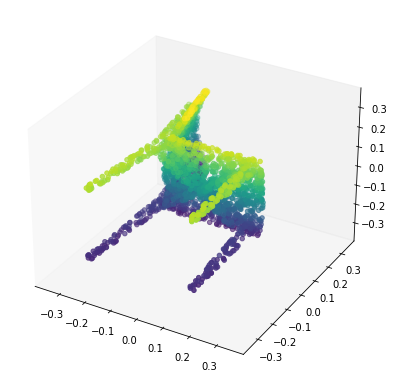

In [214]:
# plot the pcd
plot_tensor_pcd(example_pcd)

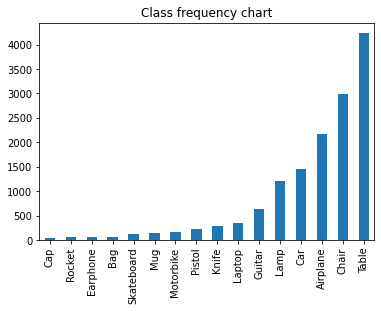

In [19]:
train_pcd_info_df['label'].value_counts().sort_values().plot(kind = 'bar');
plt.title('Class count chart');

### Data Loaders

Create data loaders that iterate over the dataset with a given batch size
and are used during the model training

In [20]:
#(Not used currently)
def my_collate(batch):
    """
    Collate function to allow different sized point clouds on the dataloaders
    It pairs each point_cloud with its label
    """
    # data = [item[0] for item in batch]
    # target = [item[1] for item in batch]
    # return [data, target]
    # simplified code:
    # same as tuple(zip(batch[0], batch[1]))
    return tuple(zip(*batch))

In [21]:
# test collate function
my_collate([[1, 2, 3], [9, 8, 7]])

((1, 9), (2, 8), (3, 7))

In [22]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True, 
                         num_workers=0)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)


In [23]:
# get one batch of point clouds and labels
pcds, labels = next(iter(train_loader))
# check the batch size
print(f'Batch size: {len(pcds)}')
print(f'Pcd data shape: {pcds.shape}')
print("One batch of labels from the train loader:")
np.array(next(iter(train_loader))[1])

Batch size: 32
Pcd data shape: torch.Size([32, 2500, 3])
One batch of labels from the train loader:


array(['Guitar', 'Airplane', 'Airplane', 'Car', 'Laptop', 'Lamp', 'Car',
       'Table', 'Pistol', 'Car', 'Chair', 'Table', 'Car', 'Airplane',
       'Airplane', 'Car', 'Car', 'Airplane', 'Guitar', 'Lamp', 'Airplane',
       'Chair', 'Lamp', 'Table', 'Airplane', 'Skateboard', 'Laptop',
       'Airplane', 'Table', 'Table', 'Table', 'Mug'], dtype='<U10')

## Model Training

### Feature Alignment Regularization

From the PointNet paper, this regularization terms uses the transformation matrix from the feature transform matrix (feature tnet)
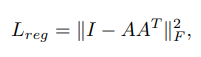


In [24]:
def feature_alignment_regularization(alignment_matrix):
    batch_size = alignment_matrix.size()[0]
    matrix_size = alignment_matrix.size()[1]
    I = torch.eye(matrix_size)
    if alignment_matrix.is_cuda:
        I = I.cuda()
    # multiply the alignment matrix by its transpose with batch matrix multiplication
    AAt = torch.bmm(alignment_matrix, torch.transpose(alignment_matrix, 1, 2))
    reg_batch = torch.norm(I - AAt, dim=(1,2))**2
    # shape: (batch_size, )
    # compute the mean of the regularization in the batch
    mean_reg = torch.mean(reg_batch)
    
    return mean_reg

In [25]:
example_tensor = torch.randn((4, 64, 64))
feature_alignment_regularization(example_tensor)

tensor(533719.5000)

### Training one Epoch

In [443]:
def train_one_epoch(model, train_loader, optimizer, classes, device):
    # activate model training mode in case its in evaluation mode
    model.train()
    # initialize tqdm progress bar
    prog_bar = tqdm(train_loader, total=len(train_loader))
    for i, data in enumerate(prog_bar):
        # reset the gradient accummulation from the previous batch
        optimizer.zero_grad()
        # get the point cloud input data and send to GPU
        pcd_input = data[0].to(device)
        # get the string target list and send to GPU
        target = data[1]
        # convert target into a numerical tensor with the indexes of the class in 
        # the classes array and send to device
        numerical_target = torch.tensor([list(classes).index(target_class) 
                                         for target_class in target])

        numerical_target = numerical_target.to(device)
        # transpose input
        # the model uses an input shape of (batch_size, 3, num_points)
        # input shape is currently (batch_size, num_points, 3)
        pcd_input = torch.transpose(pcd_input, 1, 2)
        # convert input tensor to doulbe (float32 instead of float64)
        pcd_input = pcd_input.to(torch.float32)
        # make a prediction with the model
        prediction, main_points, input_transform, feature_transform = model(pcd_input)

        # compute the negative log likelihood loss 
        loss = F.nll_loss(prediction, numerical_target)
        # add the feature alignment regularization loss with weight = 0.001 (from the paper)
        loss += 0.001 * feature_alignment_regularization(feature_transform)

        # backpropagate the loss gradient
        loss.backward()
        # uptade parameters
        optimizer.step()

        # print the loss at each iteration
        prog_bar.set_description(desc=f"Loss: {loss:.4f}")
        
    # print the final loss of the epoch
    print(loss.item())


In [418]:
classes = train_dataset.classes
# detect the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# initialize model and send to device
pointnet_cls = PointNetClassifier(num_classes=len(classes))
pointnet_cls = pointnet_cls.to(device)
# initialize Adam optimizer with default parameters (like the paper)
optimizer = Adam(pointnet_cls.parameters(), lr=0.001, betas=(0.9, 0.999))

# train 3 epochs
for i in range(3):
    print(f"Starting epoch {i+1}")
    train_one_epoch(pointnet_cls, train_loader, optimizer, classes, device)

print('training done')

Starting epoch 1


  0%|          | 0/445 [00:00<?, ?it/s]

-0.7782245874404907
Starting epoch 2


  0%|          | 0/445 [00:00<?, ?it/s]

-0.8508592844009399
Starting epoch 3


  0%|          | 0/445 [00:00<?, ?it/s]

-0.7895519137382507
training done


## Evaluate

In [419]:
def evaluate_model(model, data_loader):
    """
    Evaluates the model on all the data from the data loader and 
    prints the average loss. 
    Returns the predicted labels and their true labels
    TODO: Precision/Recall F1 score
    """
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    loss_list = np.array([])
    total_predictions = torch.tensor([])
    total_true_labels = torch.tensor([])
    
    for i, data in enumerate(prog_bar):
        # get the point cloud input data and send to GPU
        pcd_input = data[0].to(device)
        # get the string target list and send to GPU
        target = data[1]
        # convert target into a numerical tensor with the indexes of the class in 
        # the classes array and send to device
        numerical_target = torch.tensor([list(classes).index(target_class) 
                                         for target_class in target])

        numerical_target = numerical_target.to(device)
        # transpose input
        # the model uses an input shape of (batch_size, 3, num_points)
        # input shape is currently (batch_size, num_points, 3)
        pcd_input = torch.transpose(pcd_input, 1, 2)
        # convert input tensor to doulbe (float32 instead of float64)
        pcd_input = pcd_input.to(torch.float32)
        # make a prediction with the model in evaluation mode
        with torch.no_grad():
            # activate evaluation mode for batchnorm layers
            model.eval()
            prediction, main_points, input_transform, feature_transform = model(pcd_input)
            # reactivate training mode
            model.train()

        # add batch predictions and true labels to total lists
        total_predictions = torch.cat((total_predictions, prediction), dim=0)    
        total_true_labels = torch.cat((total_true_labels, numerical_target), dim=0)    
            
        # compute the negative log likelihood loss 
        loss = F.nll_loss(prediction, numerical_target)
        # add the feature alignment regularization loss with weight = 0.001 (from the paper)
        loss += 0.001 * feature_alignment_regularization(feature_transform)
        # add the loss into the loss list
        loss_list = np.append(loss_list, loss)
        
        # print the loss at each iteration
        prog_bar.set_description(desc=f"Loss: {loss:.4f}")
        
    # print the final evaluation mean loss
    print(loss_list.mean())
    
    # convert to numpy integer arrays
    total_predictions = total_predictions.argmax(dim=1).numpy()
    total_true_labels = total_true_labels.numpy().astype(int)
    # return total predictions and total true_labels
    return total_predictions, total_true_labels

In [420]:
y_pred_test, y_true_test = evaluate_model(pointnet_cls, test_loader)

  0%|          | 0/112 [00:00<?, ?it/s]

-0.8412954360246658


In [421]:
# predict the training set
y_pred_train, y_true_train = evaluate_model(pointnet_cls, train_loader)

  0%|          | 0/445 [00:00<?, ?it/s]

-0.8457673667521959


## Save model

In [463]:
model_name = 'pointnet_model_1'
model_path = os.path.join('trained_models', model_name)
# only state dict, wont work if the model architecture is changed
#torch.save(pointnet_cls.state_dict(), model_path)
# save entire model, not only state dict, doesnt matter if we change the architecture
#torch.save(pointnet_cls, model_path)

## Confusion Matrix

Test total accuracy: 0.8568213783403656


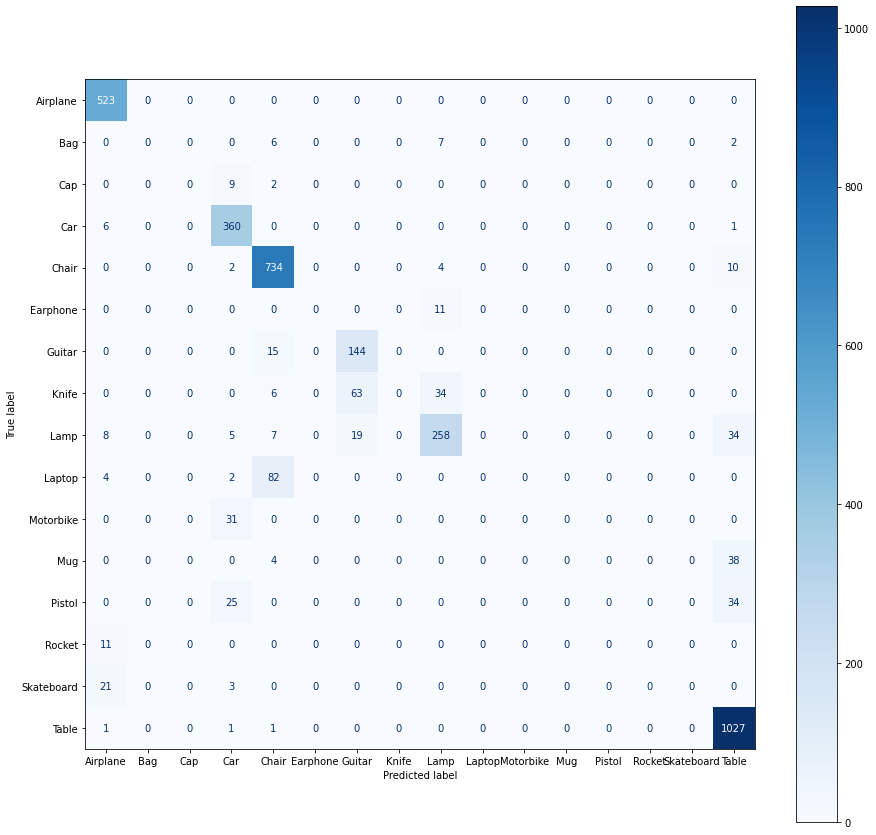

In [451]:
#test
# accuracy
test_acc = (y_true_test == y_pred_test).sum() / len(y_true_test)
print(f"Test total accuracy: {test_acc}")

conf_matrix = confusion_matrix(y_true_test, y_pred_test)
conf_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                       display_labels=classes)

fig, ax = plt.subplots(figsize=(15,15))
conf_display.plot(cmap=plt.cm.Blues, ax=ax);

Test total accuracy: 0.859423347398031


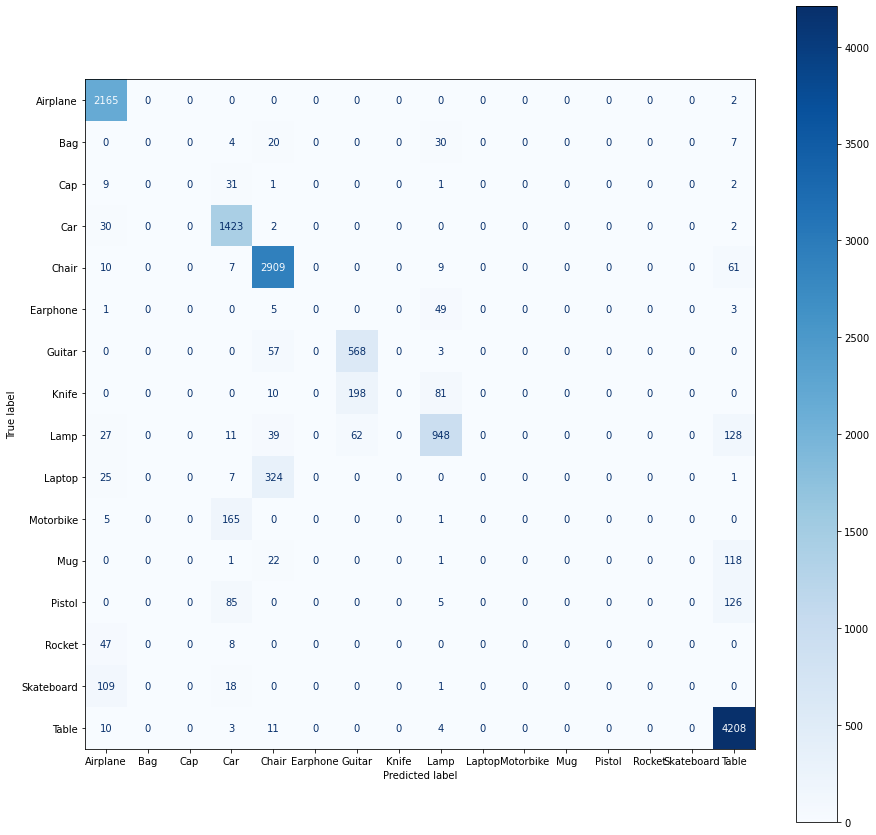

In [452]:
# train
# accuracy
test_acc = (y_true_train == y_pred_train).sum() / len(y_true_train)
print(f"Test total accuracy: {test_acc}")


conf_matrix = confusion_matrix(y_true_train, y_pred_train)
conf_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                       display_labels=classes)

fig, ax = plt.subplots(figsize=(15,15))
conf_display.plot(cmap=plt.cm.Blues, ax=ax);

In [437]:
def predict_one(model, pcd, label, show_main_points = True):
    """
    Shows one prediction and plots the point clouds and the main points used
    TODO plot transformation from input_transform
    """
    # plot the input point cloud
    plot_tensor_pcd(test_pcd)

    # convert to float32
    test_input = test_pcd.to(torch.float32)
    # transpose input
    test_input = test_input.transpose(0, 1)
    # add batch dimension
    test_input = test_input.unsqueeze(dim=0)

    with torch.no_grad():
        # activate evaluation mode for batchnorm layers
        model.eval()
        prediction, main_points, _ = model(test_input)
        # reactivate training mode
        model.train()

    if show_main_points:
        # select the main points chosen for the prediction from the input point cloud
        main_points_pcd = test_pcd[main_points.squeeze()]
        # plot the main points chosen for the prediction
        plot_tensor_pcd(main_points_pcd)    

    # check the predicted class
    predicted_class_id = prediction.numpy().argmax()
    predicted_class = classes[predicted_class_id]
    print(f"Predicted class: {predicted_class}")
    print(f"True class: {test_label}")

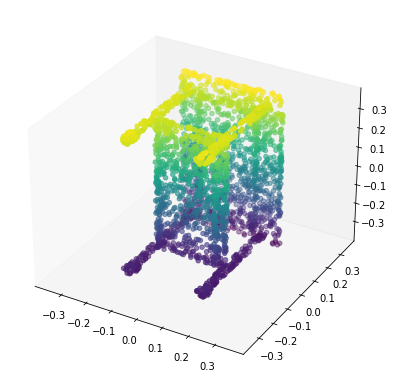

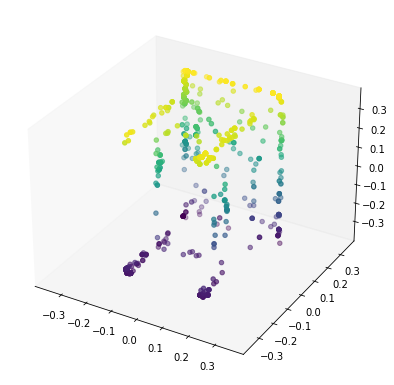

Predicted class: Table
True class: Table


In [449]:
# select one input pcd
test_pcd, test_label = next(iter(train_loader))
test_pcd = test_pcd[0]
test_label = test_label[0]

predict_one(pointnet_cls, test_pcd, test_label, show_main_points = True)